### 策略擬定

* 先區分 feature 種類 
    * numeric -> 找出與 price 有相關性
        * TotalBsmtSF: Total square feet of basement area 
        * 1stFlrSF: First Floor square feet 
        * FullBath: Full bathrooms above grade 
        * TotRmsAbvGrd: Total rooms above grade (does not include bathrooms) 
        * YearBuilt: Original construction date 
        * YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
    
    
    
* correlation between GarageCars and GarageArea is very high (0.89) 

### fill na

```
all$GarageYrBlt[is.na(all$GarageYrBlt)] <- all$YearBuilt[is.na(all$GarageYrBlt)]

#fixing 3 values for house 2577
all$GarageCars[2577] <- 0
all$GarageArea[2577] <- 0
all$GarageType[2577] <- NA

all$GarageType[is.na(all$GarageType)] <- 'No Garage'
all$GarageFinish[is.na(all$GarageFinish)] <- 'None'
all$GarageQual[is.na(all$GarageQual)] <- 'None'
all$GarageCond[is.na(all$GarageCond)] <- 'None'

#Imputing modes.
all$BsmtFinType2[333] <- names(sort(-table(all$BsmtFinType2)))[1]
all$BsmtExposure[c(949, 1488, 2349)] <- names(sort(-table(all$BsmtExposure)))[1]
all$BsmtCond[c(2041, 2186, 2525)] <- names(sort(-table(all$BsmtCond)))[1]
all$BsmtQual[c(2218, 2219)] <- names(sort(-table(all$BsmtQual)))[1]

all$BsmtQual[is.na(all$BsmtQual)] <- 'None'
all$BsmtCond[is.na(all$BsmtCond)] <- 'None'
all$BsmtExposure[is.na(all$BsmtExposure)] <- 'None'
all$BsmtFinType1[is.na(all$BsmtFinType1)] <- 'None'
all$BsmtFinType2[is.na(all$BsmtFinType2)] <- 'None'


all$MasVnrType[is.na(all$MasVnrType)] <- 'None'
all$MasVnrArea[is.na(all$MasVnrArea)] <-0
```

In [1]:
%matplotlib inline

import os, sys, csv
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from xgboost import XGBClassifier, XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR
from sklearn.linear_model import LinearRegression

/net/account/pixuser/wayne/python-env/p362/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/net/account/pixuser/wayne/python-env/p362/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#knn = KNeighborsClassifier()
lr = LinearRegression()
rf = RandomForestRegressor()
xgb = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
                      objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, 
                      gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
                      colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
                      random_state=0, seed=None, missing=None)

In [3]:
base_path = '../data/house-prices-advanced-regression-techniques'
!ls {base_path}

data_description.txt   sample_submission.csv.gz  test.csv.gz  train.csv.gz
sample_submission.csv  test.csv			 train.csv


In [11]:
train = pd.read_csv(os.path.join(base_path, 'train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))
#label = pd.read_csv(os.path.join(base_path, 'trainLabels.csv'), header=None)
print(train.shape)
#print(label.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [12]:
y = train['SalePrice']
train = train.drop('SalePrice', axis=1)

In [13]:
features = pd.concat([train, test], keys=['train', 'test'])

In [14]:
features.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [75]:
#features = pd.concat([train, test], keys=['train', 'test'])

In [15]:
chech_null = pd.DataFrame(features.isnull().sum(), columns=['Train'])
print(chech_null[chech_null['Train'] > 200].index.values)
features = features.drop(list(chech_null[chech_null['Train'] > 200].index.values) + ['Utilities'], axis=1, errors='ignore')
#train = train.drop(list(chech_null[chech_null['Train'] > 100].index.values) + ['Utilities'], axis=1, errors='ignore')
#test = test.drop(list(chech_null[chech_null['Train'] > 100].index.values) + ['Utilities'], axis=1, errors='ignore')

['LotFrontage' 'Alley' 'FireplaceQu' 'PoolQC' 'Fence' 'MiscFeature']


In [77]:
corrmat = train.corr()
corrmat[['SalePrice']].sort_values(by=['SalePrice'], ascending=True).head(11)

,SalePrice
KitchenAbvGr,-0.135907
EnclosedPorch,-0.128578
MSSubClass,-0.084284
OverallCond,-0.077856
YrSold,-0.028923
LowQualFinSF,-0.025606
Id,-0.021917
MiscVal,-0.021190
BsmtHalfBath,-0.016844
BsmtFinSF2,-0.011378


###  Fill NA

In [22]:
#train[['GarageCond']].loc[[227]]

features[['GarageFinish','GarageQual','GarageType','GarageYrBlt','GarageCond']] = \
    features[['GarageFinish','GarageQual','GarageType','GarageYrBlt','GarageCond']].fillna('NoGarage')
    
features[['GarageFinish','GarageQual','GarageType','GarageYrBlt','GarageCond']] = \
    features[['GarageFinish','GarageQual','GarageType','GarageYrBlt','GarageCond']].fillna('NoGarage')

features[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = \
    features[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna('NoBSMT')  

for _col in list(features.columns[features.isnull().sum() > 0]):
    features[_col] = features[_col].fillna(features[_col].mode()[0])
#features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])
#features['MasVnrArea'] = features['MasVnrArea'].fillna(features['MasVnrArea'].mode()[0])
#features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

features[['MSSubClass','MoSold','YrSold']] = features[['MSSubClass','MoSold','YrSold']].astype(str)

In [23]:
# Check any number of columns with NaN
print(features.isnull().any().sum(), ' / ', len(features.columns))
# Check any number of data points with NaN
print(features.isnull().any(axis=1).sum(), ' / ', len(test))

0  /  73
0  /  1459


In [125]:
# Check any number of columns with NaN
print(train.isnull().any().sum(), ' / ', len(train.columns))
# Check any number of data points with NaN
print(train.isnull().any(axis=1).sum(), ' / ', len(test))

0  /  74
0  /  1459


In [99]:
print(train.dtypes.unique())
print(train.select_dtypes(include=['O']).columns.tolist())

[dtype('int64') dtype('O') dtype('float64')]
['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


### Label encoding/factorizing

```

LandSlope 'Sev'=0, 'Mod'=1, 'Gtl'=2
Street 'Grvl'=0, 'Pave'=1
PavedDrive 'N'=0, 'P'=1, 'Y'=2


Changing some numeric variables into factors
YrSold, MoSold, MSSubClass

LabelEncoder
 'LotShape','LandSlope','MasVnrType','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',
 'BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir','KitchenQual','Functional','GarageFinish'
 'GarageQual','GarageCond','PavedDrive'

OneHotEncoder
 'MSZoning','Street','LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType',
 'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Foundation','Heating','Electrical',
 'GarageType','SaleType','SaleCondition'

```

In [150]:
#features = pd.concat([train, test], keys=['train', 'test'])

In [24]:
features_dm = pd.get_dummies(features[['MSZoning','Street','LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType',
'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Foundation','Heating','Electrical',
'GarageType','SaleType','SaleCondition','MSSubClass','MoSold','YrSold']],
               prefix=['MSZoning','Street','LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType',
'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Foundation','Heating','Electrical',
'GarageType','SaleType','SaleCondition','MSSubClass','MoSold','YrSold'])

In [100]:
train_dm = pd.get_dummies(train[['MSZoning','Street','LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType',
'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Foundation','Heating','Electrical',
'GarageType','SaleType','SaleCondition','MSSubClass','MoSold','YrSold']],
               prefix=['MSZoning','Street','LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType',
'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Foundation','Heating','Electrical',
'GarageType','SaleType','SaleCondition','MSSubClass','MoSold','YrSold'])

test_dm = pd.get_dummies(test[['MSZoning','Street','LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType',
'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Foundation','Heating','Electrical',
'GarageType','SaleType','SaleCondition','MSSubClass','MoSold','YrSold']],
               prefix=['MSZoning','Street','LotConfig','LandContour','Neighborhood','Condition1','Condition2','BldgType',
'HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Foundation','Heating','Electrical',
'GarageType','SaleType','SaleCondition','MSSubClass','MoSold','YrSold'])

In [101]:
for col in ['LotShape','LandSlope','MasVnrType','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',
 'BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir','KitchenQual','Functional','GarageFinish',
 'GarageQual','GarageCond','PavedDrive']:
    print(col, train[col].unique())

LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandSlope ['Gtl' 'Mod' 'Sev']
MasVnrType ['BrkFace' 'None' 'Stone' 'BrkCmn']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual ['Gd' 'TA' 'Ex' 'NoBSMT' 'Fa']
BsmtCond ['TA' 'Gd' 'NoBSMT' 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'NoBSMT']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'NoBSMT' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'NoBSMT' 'ALQ' 'Rec' 'LwQ' 'GLQ']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
CentralAir ['Y' 'N']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
Functional ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
GarageFinish ['RFn' 'Unf' 'Fin' 'NoGarage']
GarageQual ['TA' 'Fa' 'Gd' 'NoGarage' 'Ex' 'Po']
GarageCond ['TA' 'Fa' 'NoGarage' 'Gd' 'Po' 'Ex']
PavedDrive ['Y' 'N' 'P']


In [25]:
features = features.drop('Id', axis=1)

In [26]:
features['LotShape'] = features['LotShape'].map({'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3})
features['LandSlope'] = features['LandSlope'].map({'Sev':0, 'Mod':1, 'Gtl':2})
features['MasVnrType'] = features['MasVnrType'].map({'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2})
features['ExterQual'] = features['ExterQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
features['ExterCond'] = features['ExterCond'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
features['BsmtQual'] = features['BsmtQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
features['BsmtCond'] = features['BsmtCond'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
features['BsmtExposure'] = features['BsmtExposure'].map({'NoBSMT':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
features['BsmtFinType1'] = features['BsmtFinType1'].map({'NoBSMT':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
features['BsmtFinType2'] = features['BsmtFinType2'].map({'NoBSMT':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
features['HeatingQC'] = features['HeatingQC'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NA': 5})
features['CentralAir'] = features['CentralAir'].map({'N':0, 'Y':1})
features['KitchenQual'] = features['KitchenQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NA': 5})
features['Functional'] = features['Functional'].map({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})
features['GarageFinish'] = features['GarageFinish'].map({'NoGarage':0, 'Unf':1, 'RFn':2, 'Fin':3})
features['GarageQual'] = features['GarageQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoGarage': 5})
features['GarageCond'] = features['GarageCond'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoGarage': 5})
features['PavedDrive'] = features['PavedDrive'].map({'N':0, 'P':1, 'Y':2})

In [152]:
train = features.loc['train'].drop('Id', axis=1)
test = features.loc['test'].drop('Id', axis=1)

In [153]:
train['LotShape'] = train['LotShape'].map({'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3})
train['LandSlope'] = train['LandSlope'].map({'Sev':0, 'Mod':1, 'Gtl':2})
train['MasVnrType'] = train['MasVnrType'].map({'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2})
train['ExterQual'] = train['ExterQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
train['ExterCond'] = train['ExterCond'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
train['BsmtQual'] = train['BsmtQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
train['BsmtCond'] = train['BsmtCond'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
train['BsmtExposure'] = train['BsmtExposure'].map({'NoBSMT':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
train['BsmtFinType1'] = train['BsmtFinType1'].map({'NoBSMT':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
train['BsmtFinType2'] = train['BsmtFinType2'].map({'NoBSMT':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
train['HeatingQC'] = train['HeatingQC'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NA': 5})
train['CentralAir'] = train['CentralAir'].map({'N':0, 'Y':1})
train['KitchenQual'] = train['KitchenQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NA': 5})
train['Functional'] = train['Functional'].map({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})
train['GarageFinish'] = train['GarageFinish'].map({'NoGarage':0, 'Unf':1, 'RFn':2, 'Fin':3})
train['GarageQual'] = train['GarageQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoGarage': 5})
train['GarageCond'] = train['GarageCond'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoGarage': 5})
train['PavedDrive'] = train['PavedDrive'].map({'N':0, 'P':1, 'Y':2})

test['LotShape'] = test['LotShape'].map({'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3})
test['LandSlope'] = test['LandSlope'].map({'Sev':0, 'Mod':1, 'Gtl':2})
test['MasVnrType'] = test['MasVnrType'].map({'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2})
test['ExterQual'] = test['ExterQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
test['ExterCond'] = test['ExterCond'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
test['BsmtQual'] = test['BsmtQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
test['BsmtCond'] = test['BsmtCond'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoBSMT': 5})
test['BsmtExposure'] = test['BsmtExposure'].map({'NoBSMT':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
test['BsmtFinType1'] = test['BsmtFinType1'].map({'NoBSMT':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
test['BsmtFinType2'] = test['BsmtFinType2'].map({'NoBSMT':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
test['HeatingQC'] = test['HeatingQC'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NA': 5})
test['CentralAir'] = test['CentralAir'].map({'N':0, 'Y':1})
test['KitchenQual'] = test['KitchenQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NA': 5})
test['Functional'] = test['Functional'].map({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})
test['GarageFinish'] = test['GarageFinish'].map({'NoGarage':0, 'Unf':1, 'RFn':2, 'Fin':3})
test['GarageQual'] = test['GarageQual'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoGarage': 5})
test['GarageCond'] = test['GarageCond'].map({'Ex':0, 'Gd':1, 'TA':2, 'Fa':3, 'Po':4, 'NoGarage': 5})
test['PavedDrive'] = test['PavedDrive'].map({'N':0, 'P':1, 'Y':2})

In [27]:
features_op = pd.concat([features, features_dm], axis=1)

In [140]:
train_op = pd.concat([train, train_dm], axis=1)
test_op = pd.concat([test, test_dm], axis=1)

In [28]:
print(features_op.dtypes.unique())
print(features_op.select_dtypes(include=['O']).columns.tolist())

[dtype('O') dtype('int64') dtype('float64') dtype('uint8')]
['MSSubClass', 'MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'GarageYrBlt', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [29]:
features_op = features_op.drop(features_op.select_dtypes(include=['O']).columns.tolist(), axis=1, errors='ignore')

In [141]:
train_op = train_op.drop(train_op.select_dtypes(include=['O']).columns.tolist(), axis=1, errors='ignore')
test_op = test_op.drop(test_op.select_dtypes(include=['O']).columns.tolist(), axis=1, errors='ignore')

(1459, 223)

In [142]:
# Check any number of columns with NaN
print(train_op.isnull().any().sum(), ' / ', len(train_op.columns))
# Check any number of data points with NaN
print(train_op.isnull().any(axis=1).sum(), ' / ', len(train_op))

0  /  236
0  /  1460


In [143]:
# Check any number of columns with NaN
print(test_op.isnull().any().sum(), ' / ', len(test_op.columns))
# Check any number of data points with NaN
print(test_op.isnull().any(axis=1).sum(), ' / ', len(train_op))

0  /  223
0  /  1460


In [107]:
train_op.describe()

,Id,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,...,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,10516.828082,2.591781,1.937671,6.099315,5.575342,1971.267808,1984.865753,0.480137,103.117123,...,0.139726,0.173288,0.160274,0.083562,0.043151,0.215068,0.225342,0.208219,0.231507,0.119863
std,421.610009,9981.264932,0.582296,0.276232,1.382997,1.112799,30.202904,20.645407,0.652104,180.731373,...,0.346821,0.378625,0.366986,0.276824,0.203266,0.411011,0.417951,0.406174,0.421940,0.324913
min,1.000000,1300.000000,0.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,365.750000,7553.500000,2.000000,2.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,730.500000,9478.500000,3.000000,2.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1095.250000,11601.500000,3.000000,2.000000,7.000000,6.000000,2000.000000,2004.000000,1.000000,164.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1460.000000,215245.000000,3.000000,2.000000,10.000000,9.000000,2010.000000,2010.000000,2.000000,1600.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Skewness: 1.882876
Kurtosis: 6.536282


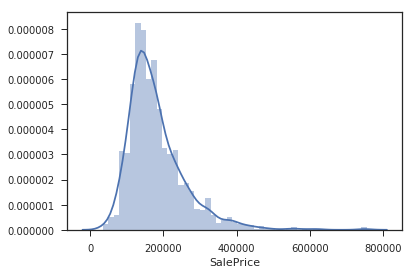

In [19]:
sns.distplot(train['SalePrice'])

#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

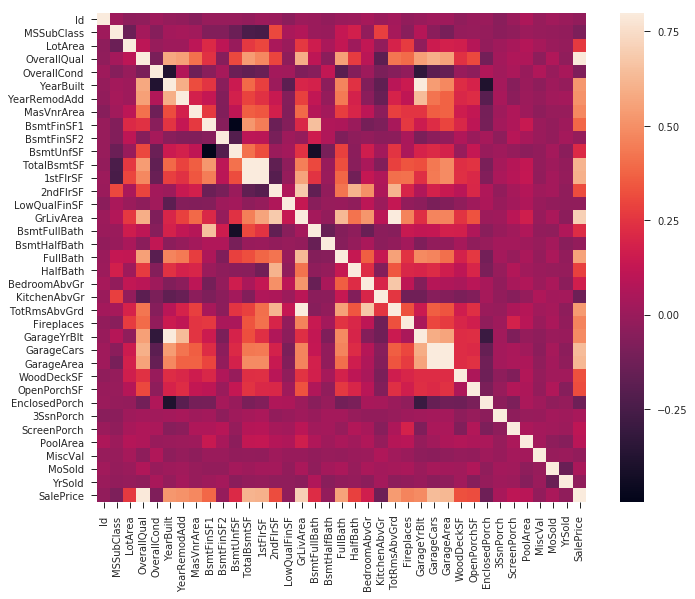

In [18]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [19]:
top_10 = corrmat[['SalePrice']].sort_values(by=['SalePrice'], ascending=False).head(11)
top_10

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [20]:
train_op[['OverallQual','SalePrice']].groupby(['OverallQual']).agg(['mean','count'])

SalePrice      
                      mean count
OverallQual                     
1             50150.000000     2
2             51770.333333     3
3             87473.750000    20
4            108420.655172   116
5            133523.347607   397
6            161603.034759   374
7            207716.423197   319
8            274735.535714   168
9            367513.023256    43
10           438588.388889    18

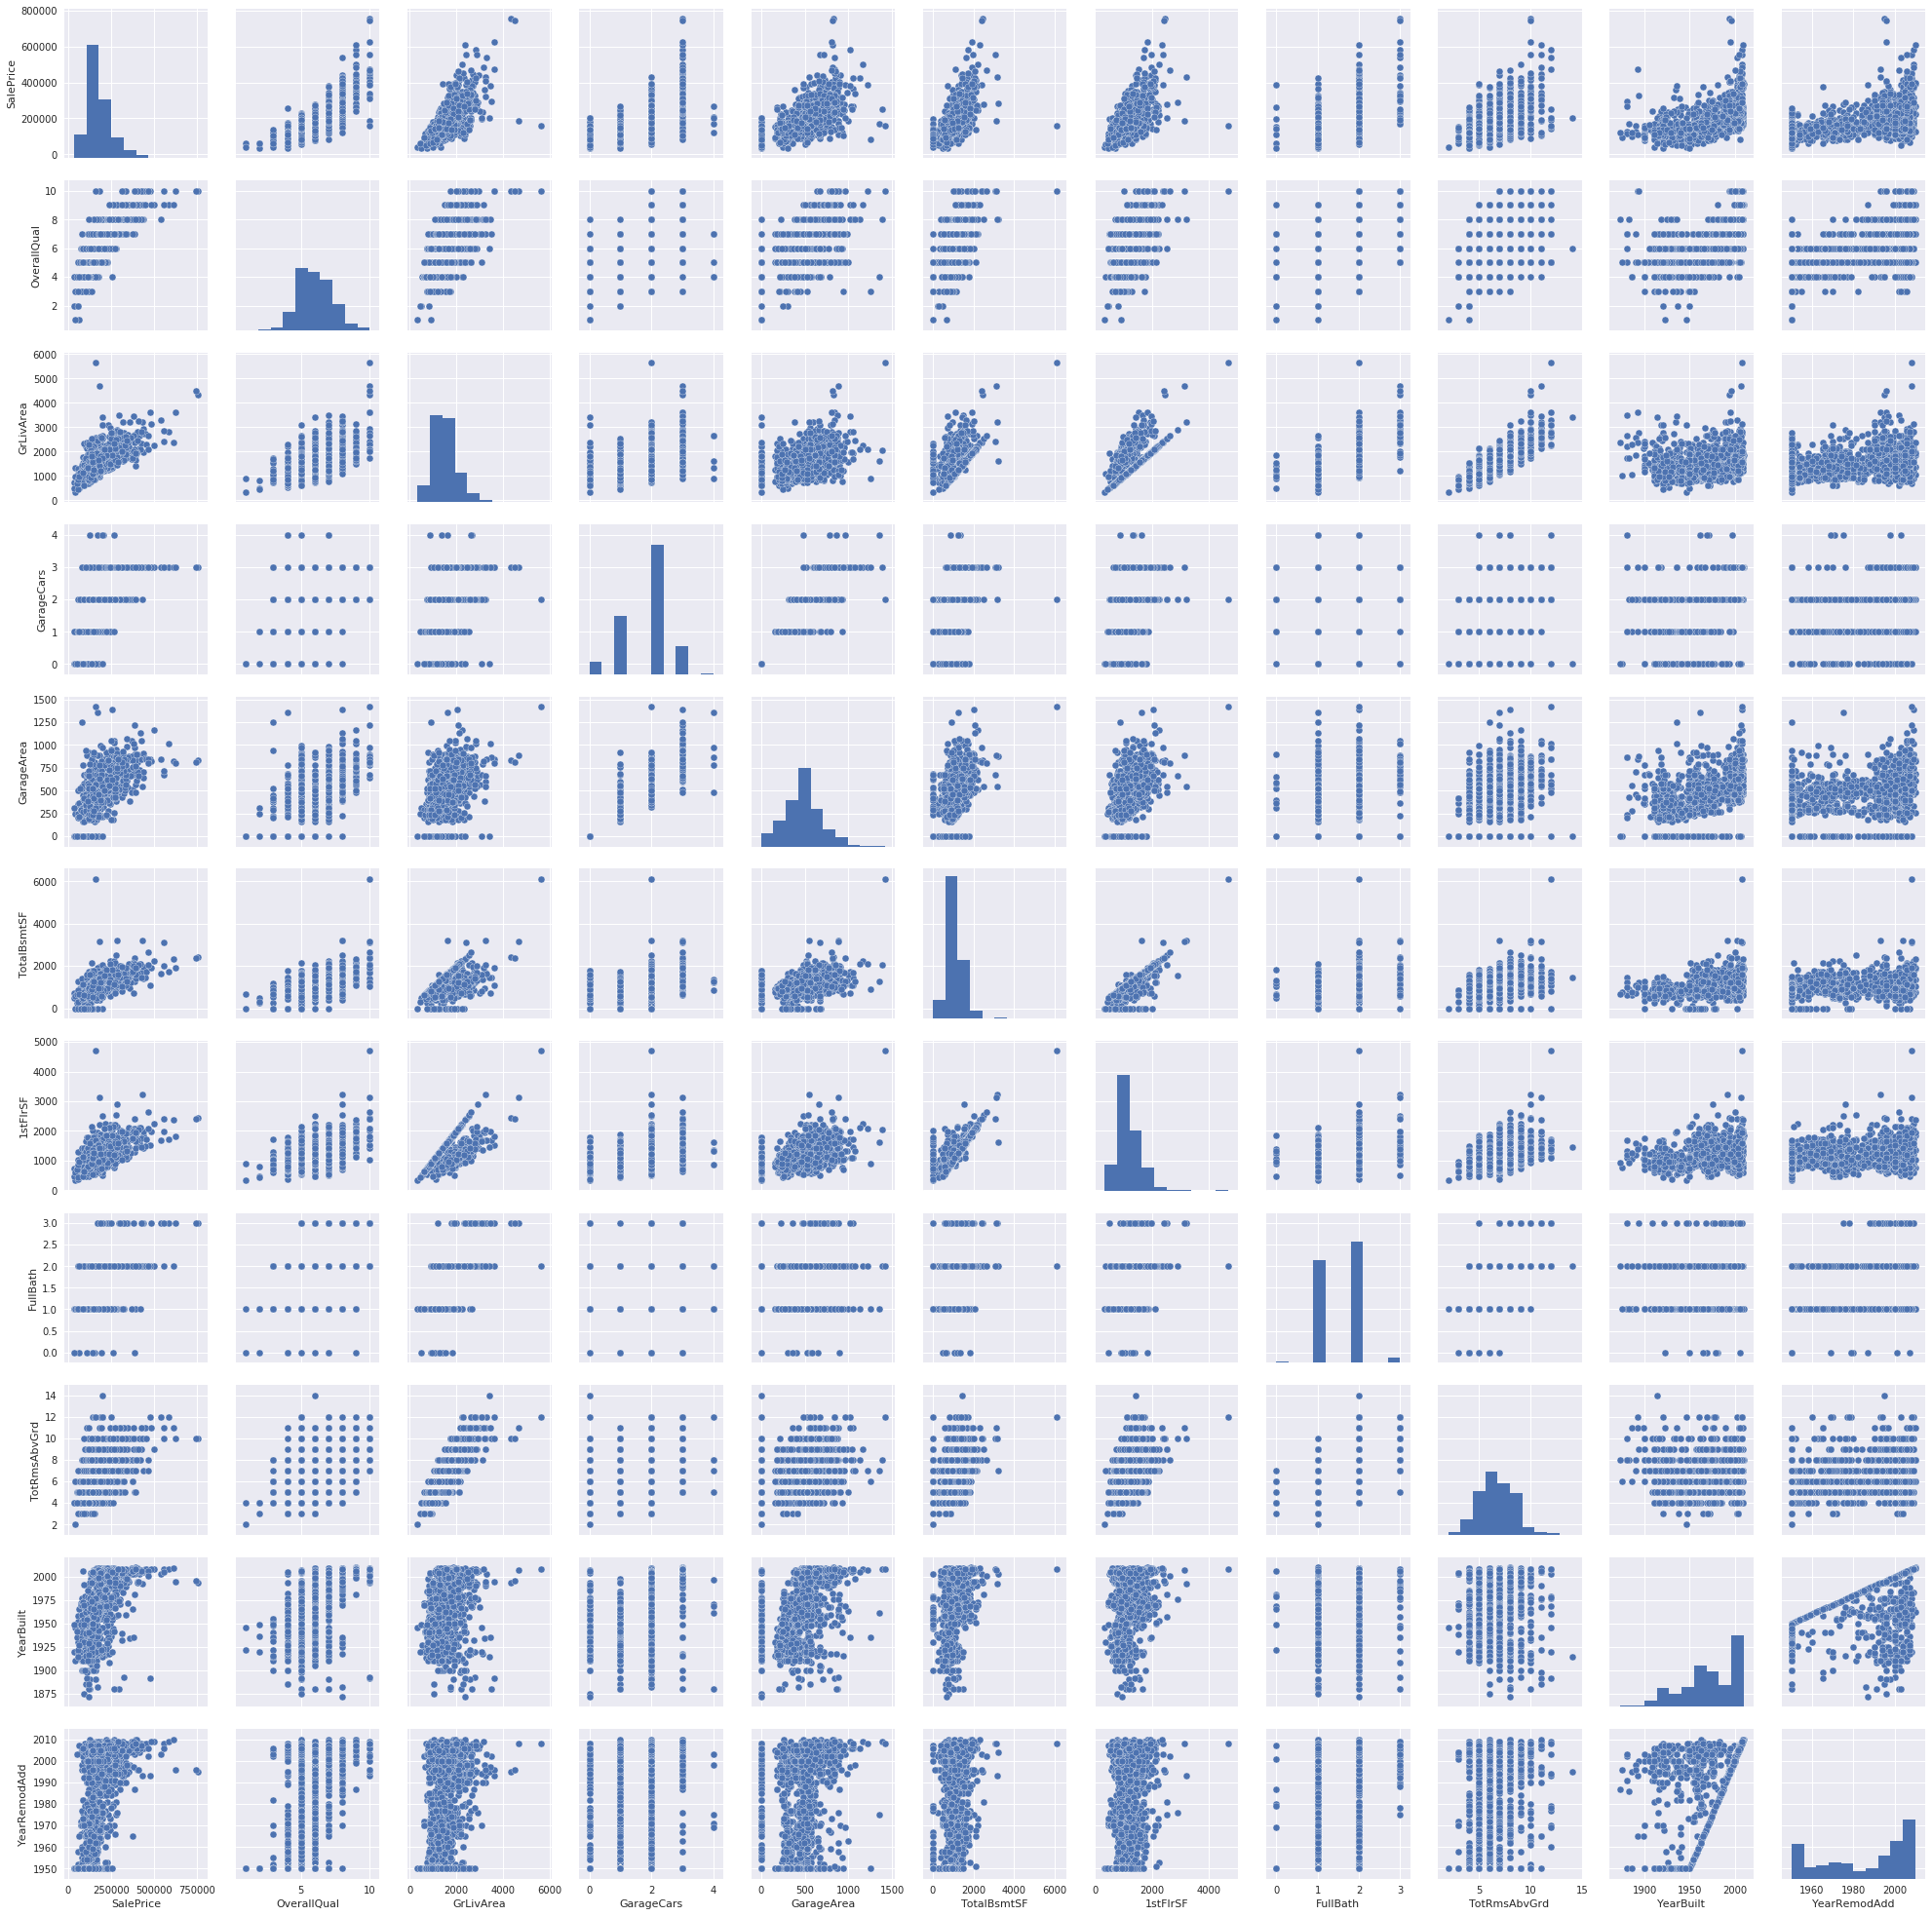

In [52]:
#scatterplot
sns.set()
#cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_attempt, size = 2.5)
plt.show();

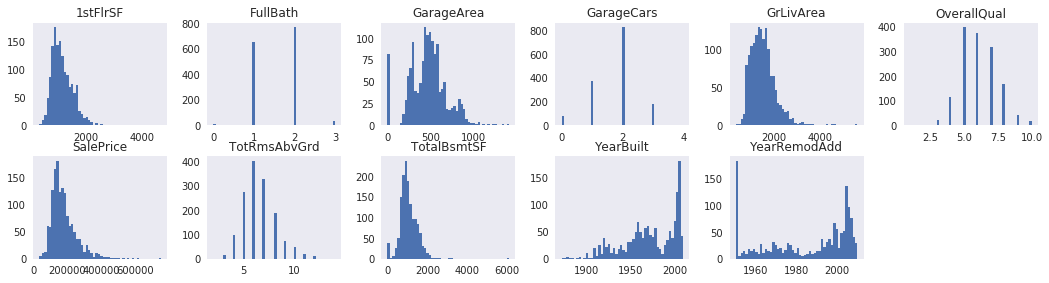

In [55]:
train_attempt.hist(bins=50, figsize=(18,24), grid=False, sharex=False, layout=(10,6));

SalePrice           AxesSubplot(0.125,0.71587;0.168478x0.16413)
OverallQual      AxesSubplot(0.327174,0.71587;0.168478x0.16413)
GrLivArea        AxesSubplot(0.529348,0.71587;0.168478x0.16413)
GarageCars       AxesSubplot(0.731522,0.71587;0.168478x0.16413)
GarageArea         AxesSubplot(0.125,0.518913;0.168478x0.16413)
TotalBsmtSF     AxesSubplot(0.327174,0.518913;0.168478x0.16413)
1stFlrSF        AxesSubplot(0.529348,0.518913;0.168478x0.16413)
FullBath        AxesSubplot(0.731522,0.518913;0.168478x0.16413)
TotRmsAbvGrd       AxesSubplot(0.125,0.321957;0.168478x0.16413)
YearBuilt       AxesSubplot(0.327174,0.321957;0.168478x0.16413)
YearRemodAdd    AxesSubplot(0.529348,0.321957;0.168478x0.16413)
dtype: object

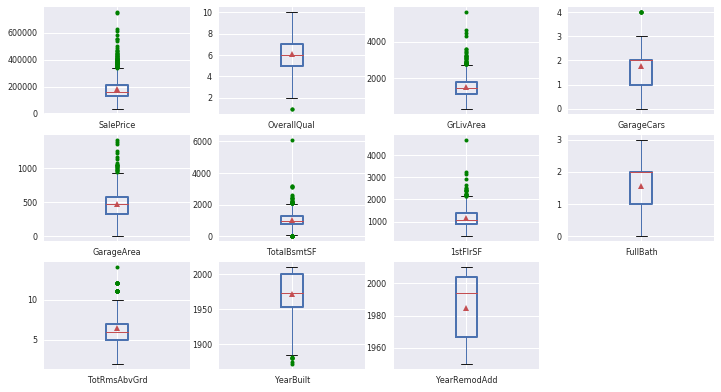

In [57]:
train_attempt.plot(fontsize=8, kind='box', boxprops={'linewidth': 2, 'markerfacecolor': 'green'},
           flierprops=dict(marker='o', markerfacecolor='green', markersize=4, linestyle='none'),
           showmeans=True, grid=True, sharex=False, sharey=False,
           subplots=True, layout=(4,4),figsize=(12, 9))

In [45]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

In [46]:
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

### Finding variable importance with a quick Random Forest


In [30]:
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV


In [31]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

In [33]:
#y = train_op['SalePrice']
#X = train_op.drop('SalePrice', axis=1)
X = features_op.loc['train']

In [34]:
gs = RandomizedSearchCV(xgb, params, n_jobs=1)  
gs.fit(X, y)  

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f20392a1c50>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f203928d320>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f203928d080>, 'colsample_bytree...2a1320>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f20392a1320>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
         

In [35]:
gs.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9849976456931007, gamma=1.9926970553906909,
       learning_rate=0.2750556819429374, max_delta_step=0, max_depth=10,
       min_child_weight=13.748365290560665, missing=None, n_estimators=13,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=39.87442370273835, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9568965867156423)

In [36]:
est = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9849976456931007, gamma=1.9926970553906909,
       learning_rate=0.2750556819429374, max_delta_step=0, max_depth=10,
       min_child_weight=13.748365290560665, missing=None, n_estimators=13,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=39.87442370273835, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9568965867156423)

In [37]:
est.fit(X, y, verbose=True)  

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9849976456931007, gamma=1.9926970553906909,
       learning_rate=0.2750556819429374, max_delta_step=0, max_depth=10,
       min_child_weight=13.748365290560665, missing=None, n_estimators=13,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=39.87442370273835, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9568965867156423)

In [38]:
y_pred = est.predict(features_op.loc['test'][list(X.columns)])

In [39]:
result = pd.DataFrame(np.column_stack([test[['Id']], y_pred]), columns=['Id', 'SalePrice'])
result[['Id']] = result[['Id']].astype(int)
result.to_csv('house-price-2.csv', index=False)